In [1]:
from os import listdir
from pickle import load
import numpy as np
import cv2

In [2]:
import keras.layers as L

In [3]:
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import Reshape
from keras.layers import concatenate
from keras.utils import plot_model

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
#reading ab files
path = "C:/Users/Lohit Reddy/OneDrive/Desktop/ML/Projects/Re-colorizer/dataset/ab/ab/"
ab_list = listdir(path)
ab=[]
for i in range(0,len(ab_list)):
    p = path + ab_list[i]
    if i==0:
        ab = np.load(p)
        print(ab.shape)
    else:
        ab= np.concatenate((ab,np.load(p)))
        print(ab.shape)
ab = tf.convert_to_tensor(ab)

FileNotFoundError: ignored

In [7]:
path_l = "C:/Users/Lohit Reddy/OneDrive/Desktop/ML/Projects/Re-colorizer/dataset/l/gray_scale.npy"
l = tf.convert_to_tensor(np.load(path_l))
l = tf.expand_dims(l, axis=3)

FileNotFoundError: ignored

In [ ]:
full_img = tf.concat((l,ab),axis = 3)
full_img.shape

TensorShape([25000, 224, 224, 3])

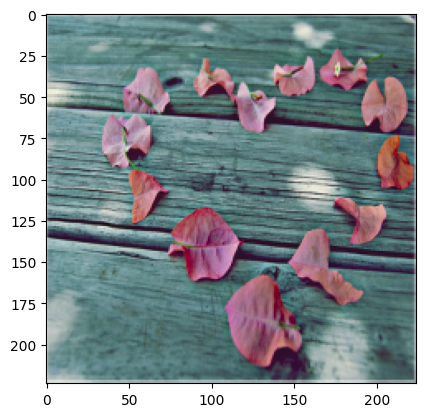

In [ ]:
img = full_img[1,:,:,:]
img = cv2.cvtColor(np.array(img), cv2.COLOR_Lab2RGB)
plt.imshow(img)

In [ ]:
#train and test split
train = full_img[:18000,:,:,:]
test = full_img[18000:,:,:,:]

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True)
datagen.fit(train)

MemoryError: Unable to allocate 10.1 GiB for an array with shape (18000, 224, 224, 3) and data type float32

In [ ]:
train_iterator = datagen.flow(train, batch_size=64)
test_iterator = datagen.flow(test, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator),
                                     len(test_iterator)))

MemoryError: Unable to allocate 10.1 GiB for an array with shape (18000, 224, 224, 3) and data type float32

In [ ]:
gray_train = train[:,:,:,1]
gray_test = test[:,:,:,1]

NameError: name 'train' is not defined

In [ ]:
def UNet():
    Xinpt = L.Input([None, None, 1])
    X0 = L.Conv2D(64, (3, 3), padding='same')(Xinpt)
    X0 = L.BatchNormalization()(X0)
    X0 = L.LeakyReLU(alpha=0.2)(X0)    #l,b,64
    X0 = L.Conv2D(64, (3, 3), strides=1, padding='same')(X0)
    X0 = L.BatchNormalization()(X0)
    X0 = L.LeakyReLU(alpha=0.2)(X0)    #l,b,64

    X1 = L.MaxPool2D((2, 2), strides=2)(X0)    #l/2,b/2,64
    X1 = L.Conv2D(128, (3, 3), padding='same')(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.LeakyReLU(alpha=0.2)(X1)
    X1 = L.Conv2D(128, (3, 3), padding='same')(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.LeakyReLU(alpha=0.2)(X1)    #l/2,b/2,128

    X2 = L.MaxPool2D((2, 2), strides=2)(X1)    #l/4,b/4,128
    X2 = L.Conv2D(256, (3, 3), padding='same')(X2)
    X2 = L.BatchNormalization()(X2)
    X2 = L.LeakyReLU(alpha=0.2)(X2)
    X2 = L.Conv2D(256, (3, 3), padding='same')(X2)
    X2 = L.BatchNormalization()(X2)
    X2 = L.LeakyReLU(alpha=0.2)(X2)    #l/4,b/4,256

    X3 = L.MaxPool2D((2, 2), strides=2)(X2)    #l/8,b/8,256
    X3 = L.Conv2D(512, (3, 3), padding='same')(X3)
    X3 = L.BatchNormalization()(X3)
    X3 = L.LeakyReLU(alpha=0.2)(X3)
    X3 = L.Conv2D(512, (3, 3), padding='same')(X3)
    X3 = L.BatchNormalization()(X3)
    X3 = L.LeakyReLU(alpha=0.2)(X3)    #l/8,b/8,512

    X4 = L.MaxPool2D((2, 2), strides=2)(X3)    #l/16,b/16,512
    X4 = L.Conv2D(1024, (3, 3), padding='same')(X4)
    X4 = L.BatchNormalization()(X4)
    X4 = L.LeakyReLU(alpha=0.2)(X4)
    X4 = L.Conv2D(1024, (3, 3), padding='same')(X4)
    X4 = L.BatchNormalization()(X4)
    X4 = L.LeakyReLU(alpha=0.2)(X4)    #l/16,b/16,1024

    X4 = L.Deconv2D(512, (2, 2), strides=2)(X4)    #l/8,b/8,512
    X4 = L.Concatenate()([X3, X4])     #l/8,b/8,1024
    X4 = L.Conv2D(512, (3, 3), padding='same')(X4)
    X4 = L.BatchNormalization()(X4)
    X4 = L.Activation('relu')(X4)
    X4 = L.Conv2D(512, (3, 3), padding='same')(X4)
    X4 = L.BatchNormalization()(X4)
    X4 = L.Activation('relu')(X4)    #l/8,b/8,512

    X3 = L.Deconv2D(256, (2, 2), strides=2)(X4)    #l/4,b.4,256
    X3 = L.Concatenate()([X2, X3])     #l/4,b/4,512
    X3 = L.Conv2D(256, (3, 3), padding='same')(X3)
    X3 = L.BatchNormalization()(X3)
    X3 = L.Activation('relu')(X3)
    X3 = L.Conv2D(256, (3, 3), padding='same')(X3)
    X3 = L.BatchNormalization()(X3)
    X3 = L.Activation('relu')(X3)    #l/4,b/4,256

    X2 = L.Deconv2D(128, (2, 2), strides=2)(X3)    #l/2,b/2,128
    X2 = L.Concatenate()([X1, X2])     #l/2,b/2,256
    X2 = L.Conv2D(128, (3, 3), padding='same')(X2)
    X2 = L.BatchNormalization()(X2)
    X2 = L.Activation('relu')(X2)
    X2 = L.Conv2D(128, (3, 3), padding='same')(X2)
    X2 = L.BatchNormalization()(X2)
    X2 = L.Activation('relu')(X2)   #l/2,b/2,128

    X1 = L.Deconv2D(64, (2, 2), strides=2)(X2)    #l,b,64
    X1 = L.Concatenate()([X0, X1])    #l,b,128
    X1 = L.Conv2D(64, (3, 3), padding='same')(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.Activation('relu')(X1)
    X1 = L.Conv2D(64, (3, 3), padding='same')(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.Activation('relu')(X1)    #l,b,64

    X0 = L.Conv2D(3, (1, 1), strides=1)(X1)     #l,b,3
    model = Model(inputs=Xinpt, outputs=X0)
    return model

In [ ]:
model = UNet()
model.compile('adam', loss='mean_squared_error', metrics=['mae', 'acc'])

In [ ]:
from IPython import display
for epoch in range(1, 101):
    display.clear_output(wait=True)
    print('Epoch:', epoch)
    model.fit(gray_train, train, batch_size=256, validation_data=(gray_test, test))
    sample_images(test, gray_test, 5)
    model.save('unet.hdf5')